# Kaggle NLP series - 1st Task - Toxic comment classification

Hi Everyone, This is the **first notebook in my NLP Kaggle series**. I took up a simple toxic comment classification in the first notebook and as the series progress I will attempt more complex NLP problems. 

###  Do upvote if you find this helpful. Let's get started. 

I am going to perform EDA and use different models for feature generation (embeddings) and classification

## Brief description about the problem:

* A large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are: toxic, severe_toxic, obscene, threat, insult and identity hate.

* I have to build a multi-headed model that’s capable of detecting different types of of toxicity


### Multiclass vs Multilabel Classification

* Let me give an example to distinguish between multiclass and multi label.

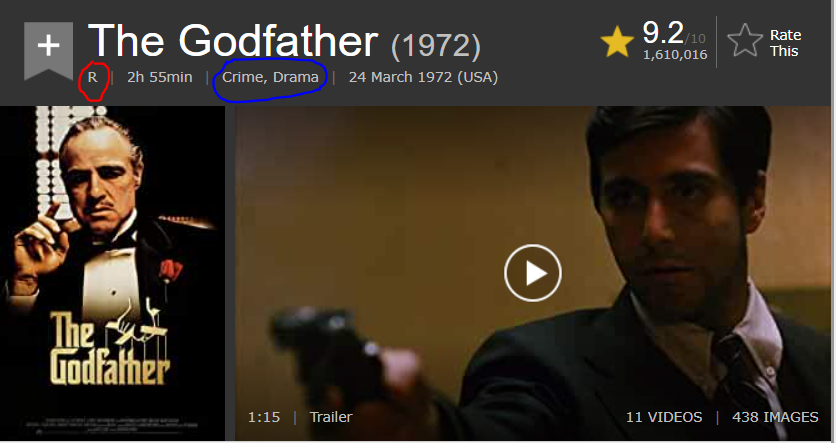

#### The Godfather movie rated as "R" which is highlighted in red. If you consider any movie there can be only one type of rating for it. It can be rated as G, or PG or R but only one type. So classifying a movie based on its rating is a **multiclass classification** problem (Each sample is assigned to only one label).

#### Now consider the genre of the same movie which is highlighted in blue. There can be a FINITE set of genres and a movie can fall into one or multiple genres. It can be a (fantasy & thriller & crime) or it can be (drama&crime), you name it. So detecting different type of genres that a movie belongs is a **multilabel classification** problem

### Downloading data from kaggle

In [1]:
!unzip -o '/kaggle/input/jigsaw-toxic-comment-classification-challenge/*.zip' -d /kaggle/working > /dev/null


4 archives were successfully processed.


## First step let's import some basic libraries and have a look at the data

In [2]:
# Importing libraries
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
samp_sub=pd.read_csv("sample_submission.csv")

print(f"Train Data Dimensions are {train.shape}")
print(f"Test Data Dimensions are {test.shape}")
print(f"Sample Submission Dimensions are {samp_sub.shape}")
train.head(3)

Train Data Dimensions are (159571, 8)
Test Data Dimensions are (153164, 2)
Sample Submission Dimensions are (153164, 7)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


In the above cell we can see a small segment of train data. We have a text_id, text and the labels. "0" and "1" are used to present the labels.

In [4]:
import plotly.express as px

df1=pd.DataFrame(train[train.columns[2:]].sum(axis=0)).reset_index()
df1["Label"]=df1["index"]
df1["Count of Comments"]=df1[0]
df1=df1.sort_values(0, ascending=False)
fig = px.bar(df1, x="Label", y="Count of Comments", title="No. of comments per label",color="Count of Comments",text="Count of Comments")
fig.update_traces( textposition='outside')
fig.show()

* From the above graph it is evident that most of the comments having toxic label
* Now let's observe the distribution os sentences based on the count of labels

In [5]:
df2=pd.DataFrame(pd.DataFrame(train[train.columns[2:]].sum(axis=1)).reset_index()[0].value_counts())
df2["Count of sentences"]=df2[0]
df2["No. of labels in a sentence"]=df2.index

fig = px.bar(df2, x="No. of labels in a sentence", y="Count of sentences", title="No of comments based on the count of labels",color="Count of sentences", text="Count of sentences")
fig.update_traces( textposition='outside')
fig.show()

* From the above graph we can see that 1,43,346 out of 1,59,571 sentences does not have any labels

### Now lets observe the sentences

In [6]:
del df1
del df2

In [7]:
for i in range(3):
    print(i, "--",train["comment_text"][i])
    print("\n")

0 -- Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


1 -- D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)


2 -- Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.




### It looks like we have sentences of all different kind of lengths.. lets see their distribution

In [8]:
from nltk import word_tokenize

train['tokenized_sents'] = train.apply(lambda row: word_tokenize(row['comment_text']), axis=1)
lengths = [len(line) for line in train["tokenized_sents"]]
px.histogram(lengths)

### It is good to see most of the sentences are falling between the range of 0-500. We have few outliers where no.of words is beyond 500. Lets look at an example

In [9]:
train["comment_text"][np.argmax(lengths)]

'YOU!\nYou blocked me worm why!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

## Ahh! This is why we need preprocessing. The reason why we have such huge length sentences is because we have lot of special characters. Lets prepocess the data and then see the distribution of sentence lengths again

In [10]:
del lengths
import re
from nltk.corpus import stopwords
stop = stopwords.words('english')

train['preprocess'] = train.apply(lambda row: row['comment_text'].replace("\n"," "), axis=1) #removes new line character
test['preprocess'] = test.apply(lambda row: row['comment_text'].replace("\n"," "), axis=1)

#removes urls
train['preprocess']=train.apply(lambda row: re.sub('http://\S+|https://\S+', 'urls',row['preprocess']).lower(), axis=1)
test['preprocess']=test.apply(lambda row: re.sub('http://\S+|https://\S+', 'urls',row['preprocess']).lower(), axis=1)

#remove all non-alphanumeric values(Except single quotes)
train['preprocess']=train.apply(lambda row: re.sub('[^A-Za-z\' ]+', '',row['preprocess']).lower(), axis=1)
test['preprocess']=test.apply(lambda row: re.sub('[^A-Za-z\' ]+', '',row['preprocess']).lower(), axis=1)

#remove stopwords as they occupy major chunk of the vocabulary
train['preprocess'] = train['preprocess'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test['preprocess'] = test['preprocess'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#removes all additional spaces
train['preprocess']=train.apply(lambda row: re.sub('  +', ' ',row['preprocess']).strip(), axis=1)
test['preprocess']=test.apply(lambda row: re.sub('  +', ' ',row['preprocess']).strip(), axis=1)

In [11]:
train['tokenized_sents'] = train.apply(lambda row: word_tokenize(row['preprocess']), axis=1)
lengths = [len(line) for line in train["tokenized_sents"]]
px.histogram(lengths)

### Great!! The maximum length reducing to 1200 because of preprocessing. Looks fine. Now lets compare few raw strings and preprocessed strings to see whether we capture all the relevant information and also lets take care of zero length rows

In [12]:
del lengths
print(train["comment_text"][70],"\n","---------------","\n",train["preprocess"][70])

"

Oppose – As the article stands, it does not properly reference under the WP:REFERENCE guidelines. If this issue is resolved, I don't any issues with it being moved to the mainspace. 「」¤ • ¢  " 
 --------------- 
 oppose article stands properly reference wpreference guidelines issue resolved issues moved mainspace


In [13]:
train["preprocess1"] = train.apply(lambda x: x["comment_text"] if len(x["preprocess"])==0 else x['preprocess'], axis=1)
test["preprocess1"] = test.apply(lambda x: x["comment_text"] if len(x["preprocess"])==0 else x['preprocess'], axis=1)

## Data preprocessed. Now lets prepare data for training

In [14]:
traindf=train[['preprocess1','toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]
testdf=test[['id','preprocess1']]

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Input

In [16]:
traind=traindf["preprocess1"]
train_label=traindf[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]
testd=testdf["preprocess1"]

In [17]:
#prepare tokenizer
tokenizer = Tokenizer(num_words = 30000) #only 30000 words i am considering here
tokenizer.fit_on_texts(traind)

#convert each text into array of integers with help of tokenizer.
train_final = tokenizer.texts_to_sequences(traind)
test_final = tokenizer.texts_to_sequences(testd)

### Now lets pad the sentences. From the above histogram it is evident that most of sentences falling in range 1-200 lengths. So I will keep max length=200. We will trim any sentence above that length and we will pad zeros for all the sentence below 200

In [18]:
traind=pad_sequences(train_final, maxlen=200)
testd=pad_sequences(test_final, maxlen=200)

In [19]:
print(traind.shape,train_label.shape)

(159571, 200) (159571, 6)


## Lets create a model and train it. As the problem belongs to mutilabel classification, final layer activation is sigmoid and loss function is binary cross entropy. We  will see auc as the performance metric

In [20]:
model = Sequential()
model.add(Embedding(30000, 128))
model.add(LSTM(units = 128, dropout = 0.2, recurrent_dropout = 0.2,return_sequences=True))
model.add(LSTM(units = 128, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(units = 6, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         3840000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 4,103,942
Trainable params: 4,103,942
Non-trainable params: 0
_________________________________________________________________


In [21]:
from sklearn.model_selection import train_test_split
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC"])
x_train, x_val, y_train, y_val = train_test_split(traind, train_label, shuffle = True, random_state = 123)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
model.fit(x_train, y_train, batch_size = 128, epochs = 1, validation_data = (x_val, y_val))

(119678, 200) (119678, 6) (39893, 200) (39893, 6)
935/935 [==============================] - 1340s 1s/step - loss: 0.0886 - auc: 0.9295 - val_loss: 0.0534 - val_auc: 0.9755


In [24]:
result = pd.merge(testdf, samp_sub, on = "id")
preds = model.predict(testd)
result[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]] = preds
result.drop(["preprocess1"], axis = 1, inplace = True)
result.to_csv("submission.csv", index = False)

## I got 95.4% as final accuracy. It can be improved by stacking hyperparameter tuning and running for more epochs. It can also be improved by using transformers pretrained models. 

# ERROR ANALYSIS - I also observed some sentences in test data belong to other languages. Some of them are shown below

In [27]:
test[test["preprocess"].str.len()==0]

,id,comment_text,preprocess,preprocess1
34,000d4f120d5a7303,일이삼사오육칠팔구하고십이요 에헤헤 으헤 으헤 으허허,,일이삼사오육칠팔구하고십이요 에헤헤 으헤 으헤 으허허
114,002c586b0af3792c,পরিচয় \n\n নাম-মোঃফরহাদ ইসলাম \n পিতা-মোঃ শ...,,পরিচয় \n\n নাম-মোঃফরহাদ ইসলাম \n পিতা-মোঃ শ...
119,003044a2c35274b6,السلام عليكم و رحمة الله و بركاته الا الجميع \...,,السلام عليكم و رحمة الله و بركاته الا الجميع \...
419,00b568d3b0f61a37,Радченко ис мы дирты гаы анал сех славе!!,,Радченко ис мы дирты гаы анал сех славе!!
506,00d2aca8d65aa590,== ޗޮޮލ! == \n\n މަލދިވެސ ިސ ަ ޕރެތތޔ ގޮޮދ ިސލ...,,== ޗޮޮލ! == \n\n މަލދިވެސ ިސ ަ ޕރެތތޔ ގޮޮދ ިސލ...
...,...,...,...,...
152562,fef5468c148e51d2,== دومین متن مباحثه با موضوع اختصاصی داعش و اس...,,== دومین متن مباحثه با موضوع اختصاصی داعش و اس...
152705,ff37eca3c02bb566,أسف أخي أي قبل الاسلام ، ولست عربية,,أسف أخي أي قبل الاسلام ، ولست عربية
152819,ff6731195127887f,== 蹩脚英语 == \n 英语好烂呀！最近跟维基用户有事要说，无奈几乎不会英语，说不了话。...,,== 蹩脚英语 == \n 英语好烂呀！最近跟维基用户有事要说，无奈几乎不会英语，说不了话。...
152934,ff9bbe71e8996418,سوال ۱۰ \n سوال ۱۰ ۔ کیا اُم المومنین حضرت عائ...,,سوال ۱۰ \n سوال ۱۰ ۔ کیا اُم المومنین حضرت عائ...


## If we use a pretrained multilingual tranformer models, there is a high chance to increase the accuracy. 

# That's all in this notebook. First task of NLP kaggle series is done. Stat tuned for the next tasks. Do upvote if you find this helpful